In [1]:
import numpy as np
import matplotlib.pyplot as plt

# get data
eeg_data = np.genfromtxt("data/joined.csv", delimiter=",").astype(np.float32)
eeg_data.shape

(12, 170752)

In [2]:
# put arrays in dictionary for labels
samples = 600*128

channels = {}
for i in range(len(eeg_data)):
    channels[f"channel_{i}"] = eeg_data[i][:samples]

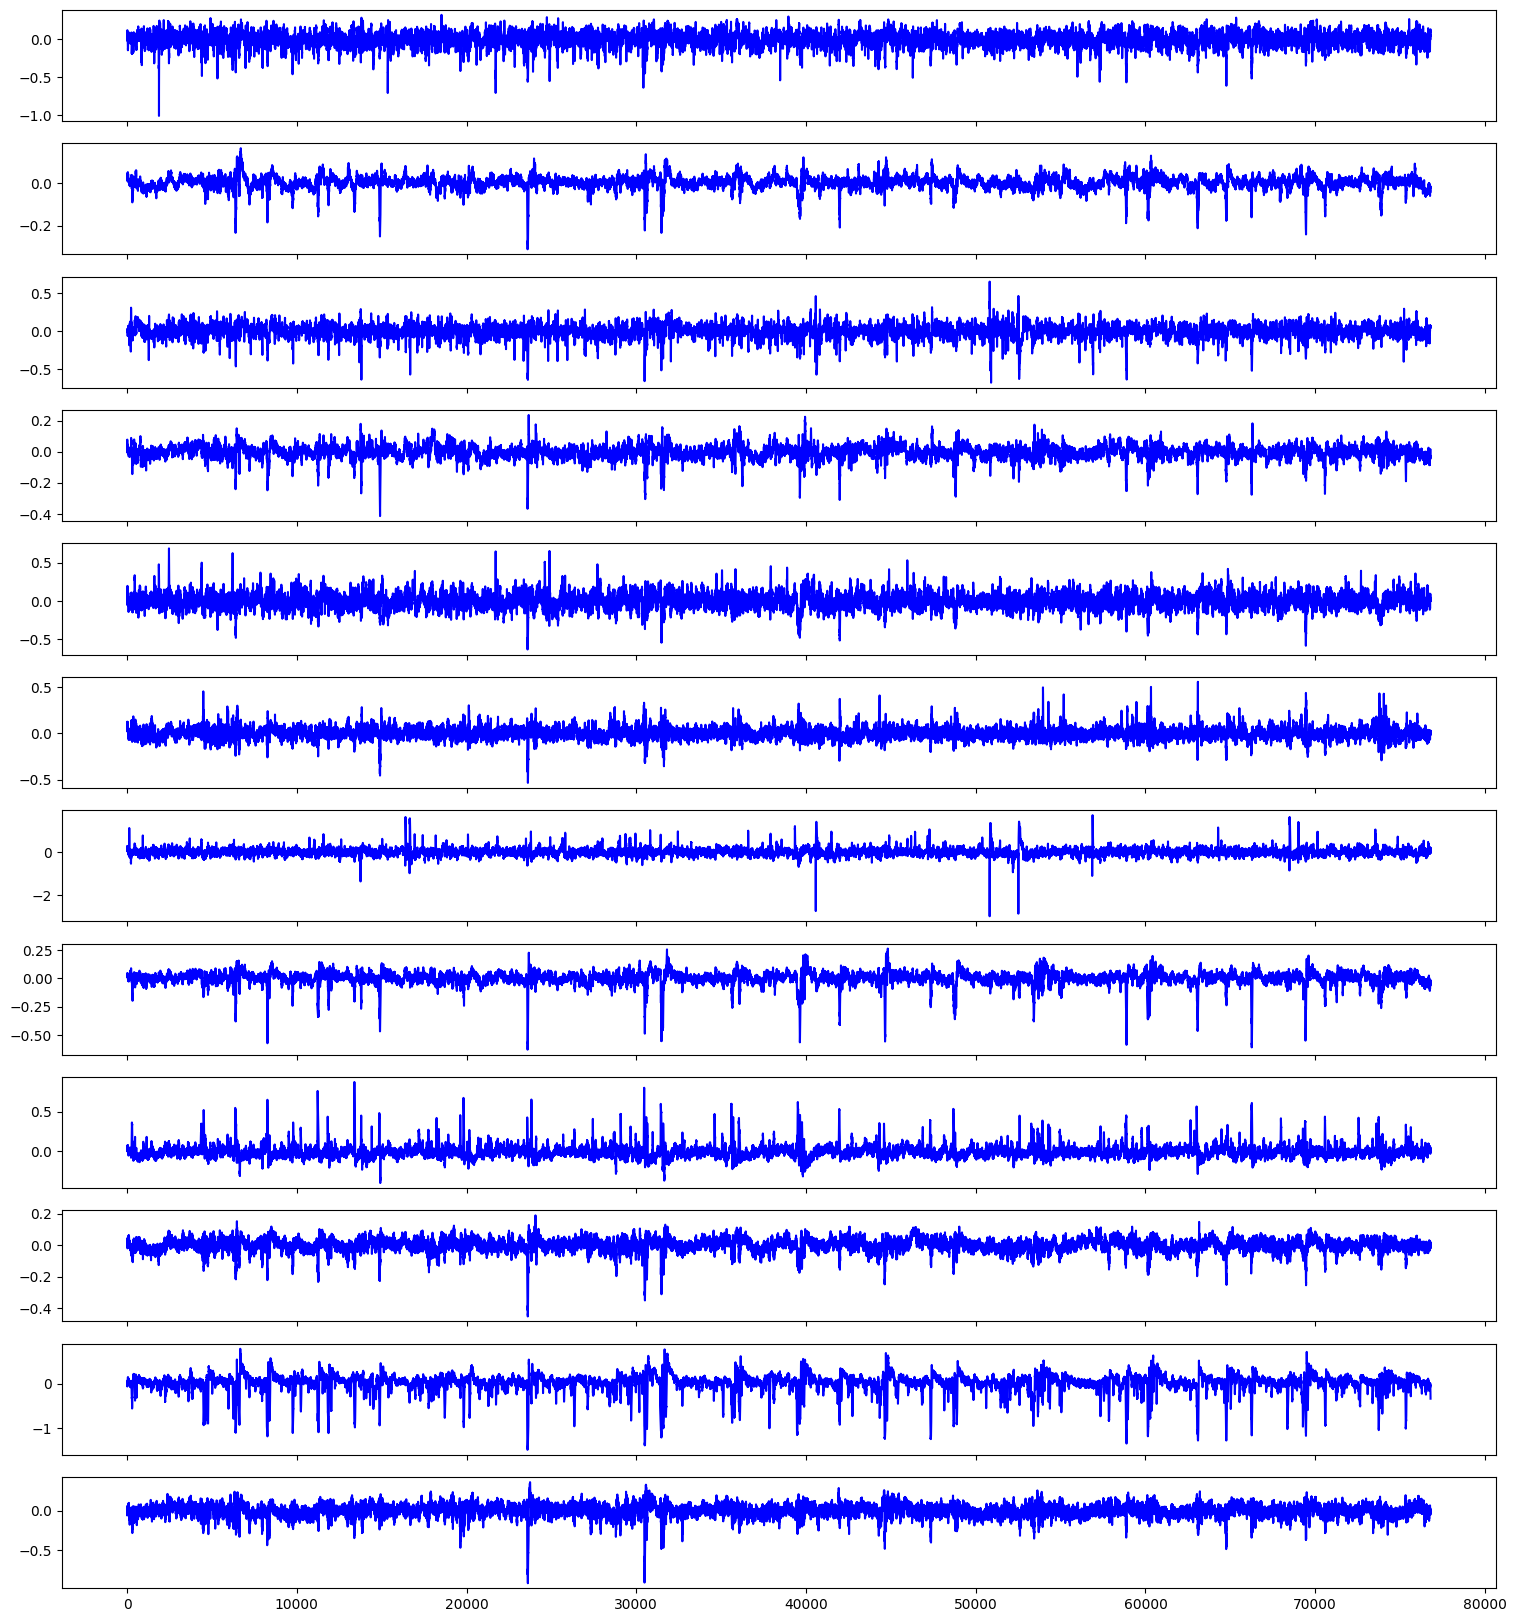

In [3]:
# plot to compare
time = [i for i in range(len(channels["channel_9"]))]

fig, axs = plt.subplots(len(channels), 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

i = 0
for c in channels:
    axs[i].plot(time, channels[c], 'b')
    i += 1

# without high-pass filtering

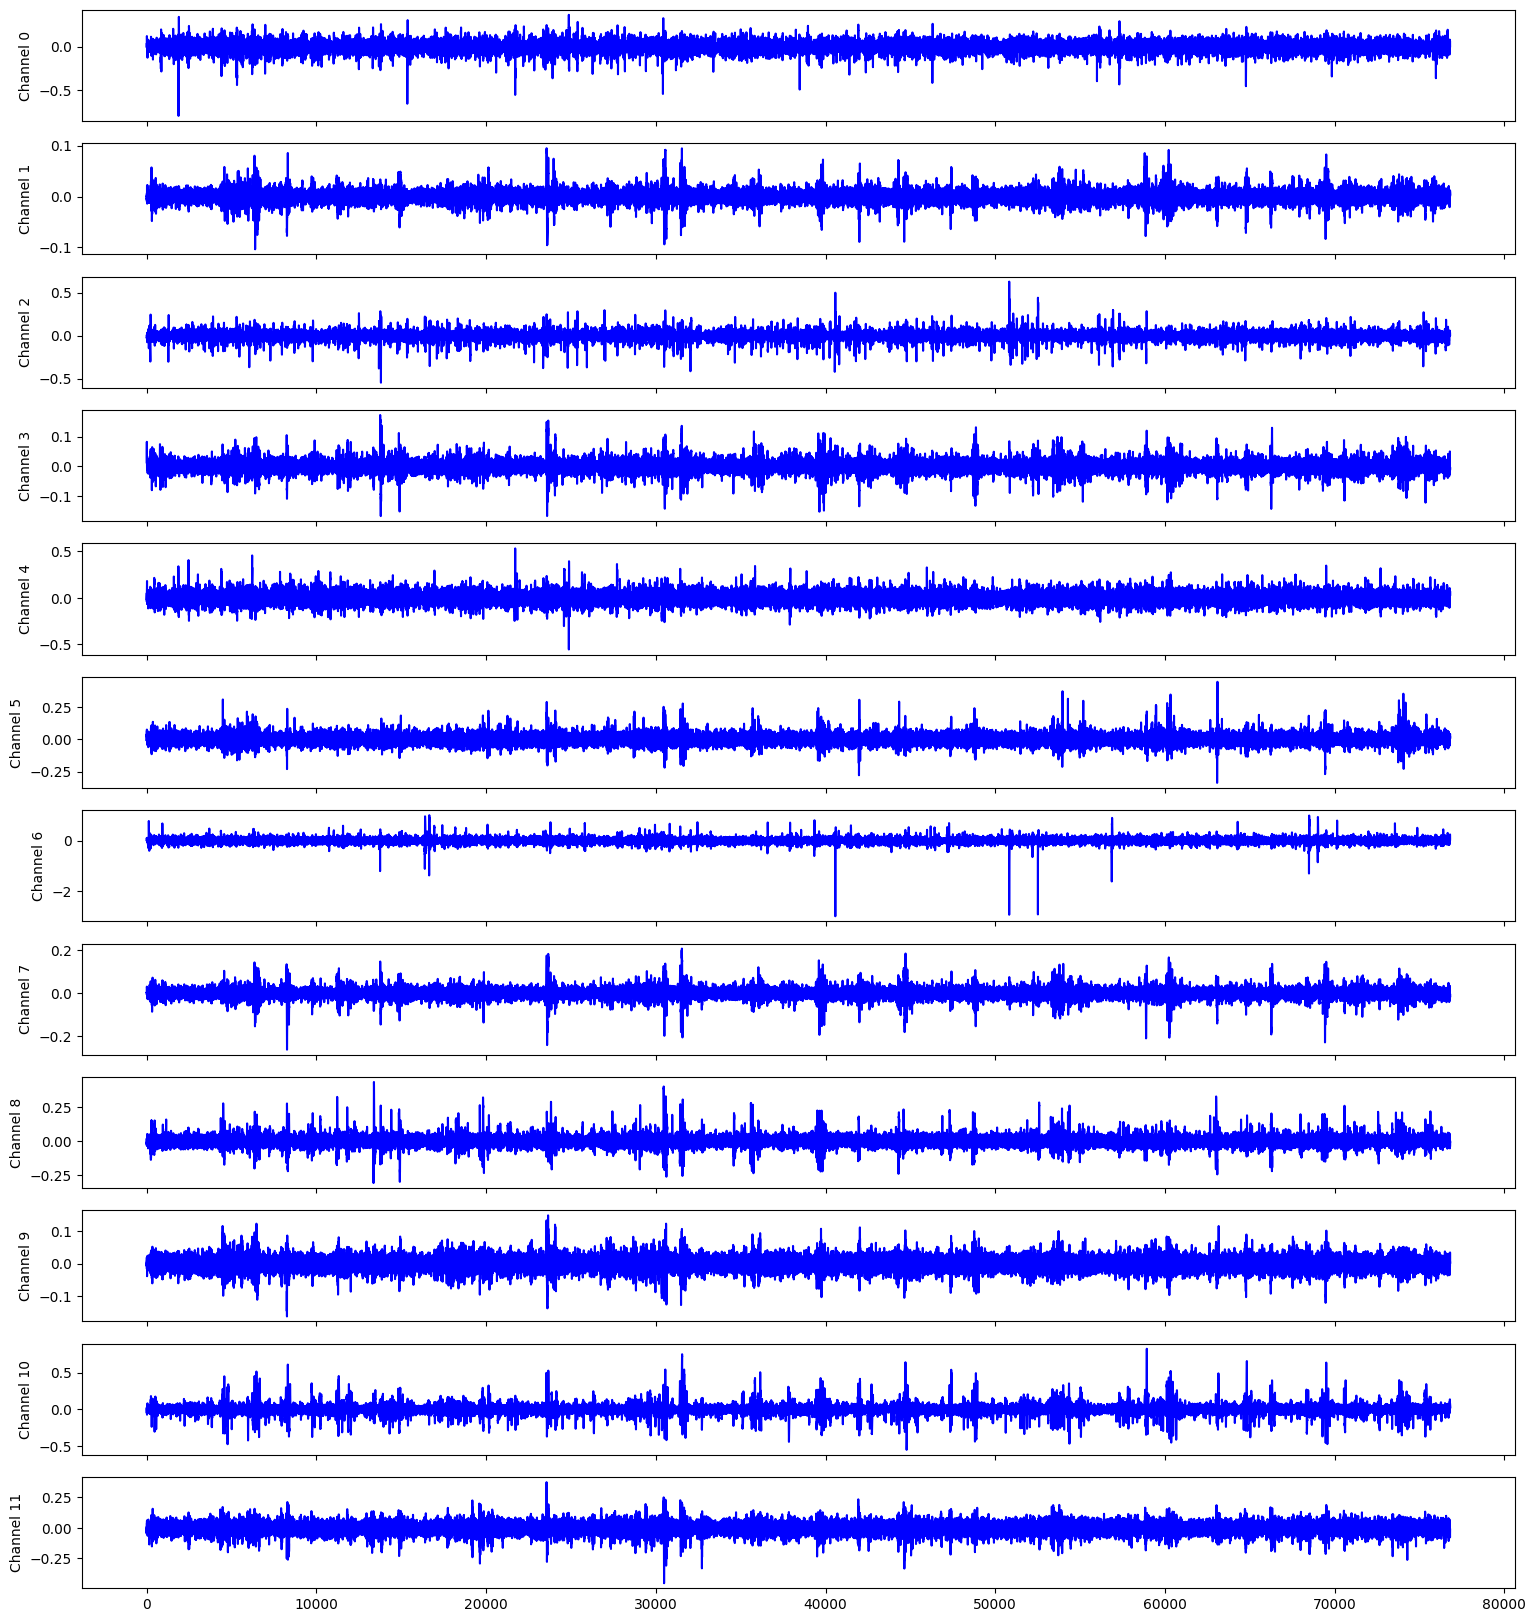

In [4]:
from scipy.signal import butter, filtfilt

# use a 2nd-order high-pass filter to filter out DC component
b, a = butter(N=2, Wn=1/(0.5*128), btype='high', analog=False)

filtered_chans = []

for ch in channels:
    filt_data = filtfilt(b, a, channels[ch])
    filtered_chans.append(filt_data)

# plot to compare
time = [i for i in range(len(filtered_chans[0]))]

fig, axs = plt.subplots(len(filtered_chans), 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(len(filtered_chans)):
    axs[c].plot(time, filtered_chans[c], 'b')
    axs[c].set_ylabel(f"Channel {c}")

# with high passed filtering

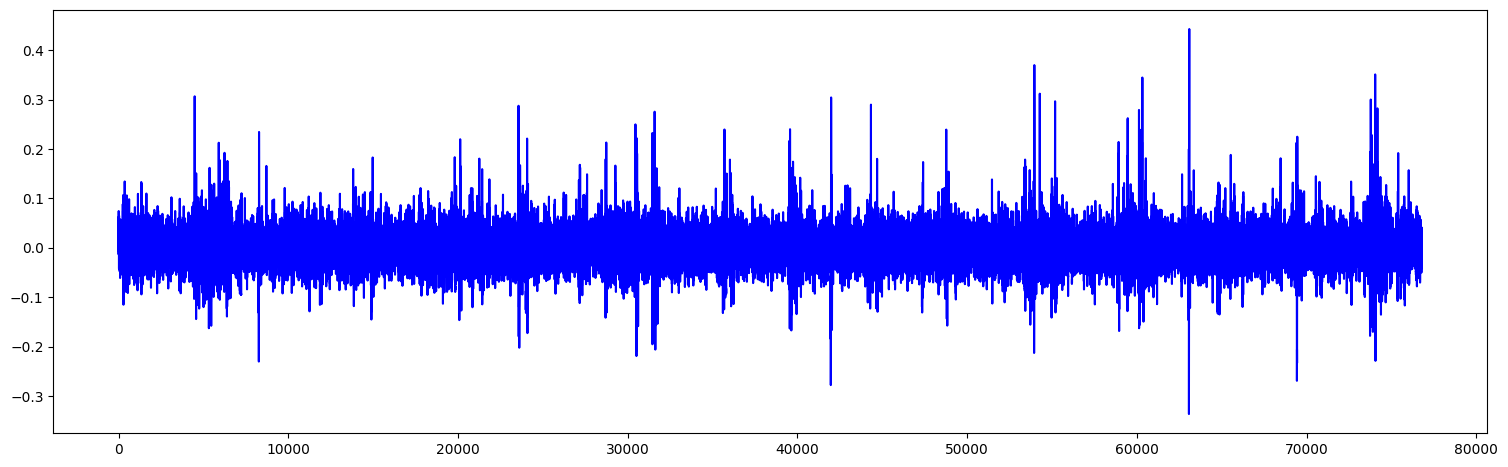

In [5]:
# initial channel data

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(time, filtered_chans[5], 'b')

In [6]:
# compute FFT 

magnitudes = np.fft.rfft(filtered_chans[5])

# estimating sample rate as "256"
sample_freq = np.fft.rfftfreq(filtered_chans[5].shape[0], 1 / 128)

print(sample_freq.shape)
print(magnitudes.shape)

(38401,)
(38401,)


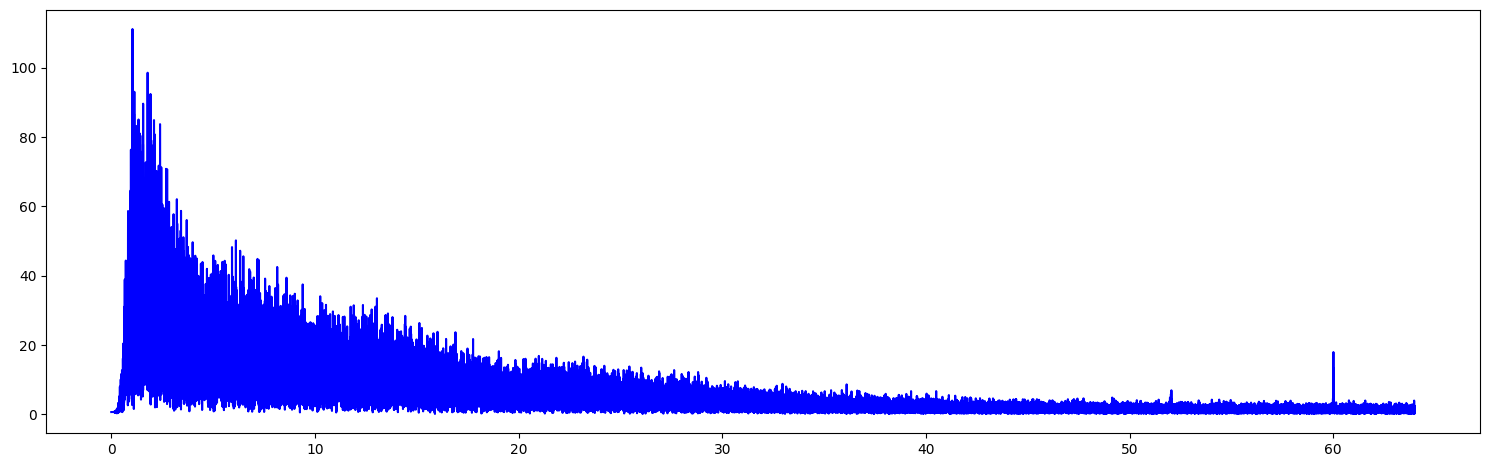

In [7]:
fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(sample_freq, abs(magnitudes), 'b')

In [8]:
# amplitude of fourier
amplitudes = abs(magnitudes)
phase = np.angle(magnitudes)

lf = np.log(amplitudes) 

length = len(lf)
val = (1 / length ** 2)
q_matrix = np.full((length, length), val)
alf = np.dot(q_matrix, lf.T) 

In [9]:
alf.shape

(38401,)

In [10]:
phase

array([ 0.00000000e+00, -7.91875481e-04, -1.58368755e-03, ...,
        2.64632557e+00, -2.56318874e-01,  0.00000000e+00])

In [11]:
rf = lf - alf
rf

array([-0.53726896, -0.53726512, -0.53725359, ...,  0.8840939 ,
        0.39127228, -0.18579244])

In [12]:
# inverse fourier

salient_non = abs(np.fft.ifft(np.exp(rf + phase * 1j)))

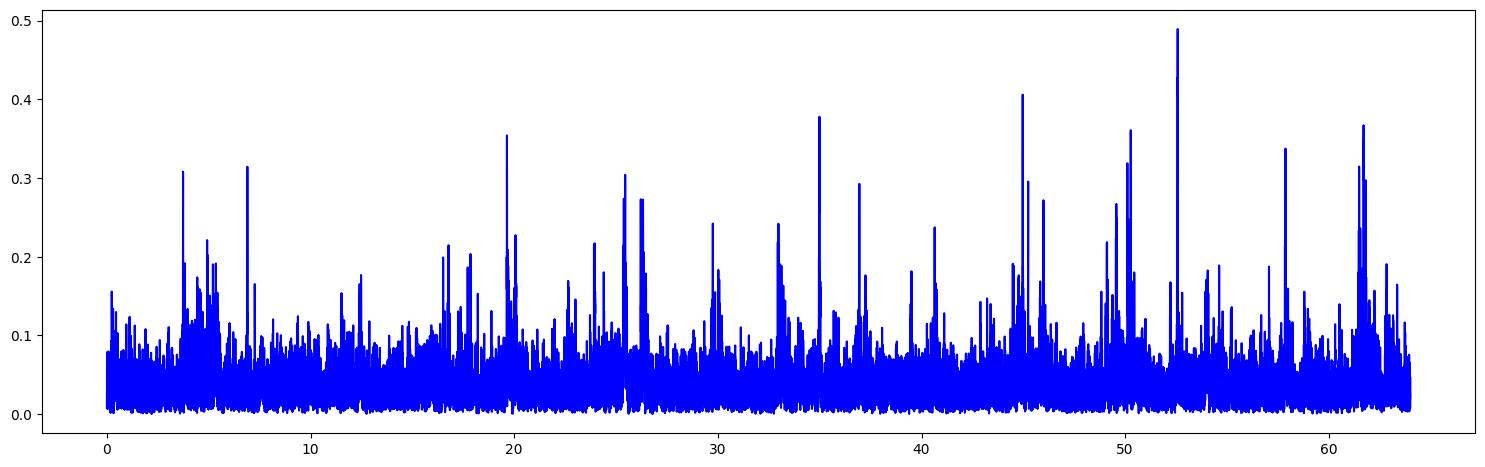

In [13]:
fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(sample_freq, salient_non, 'b')

In [14]:
len(salient_non)

38401

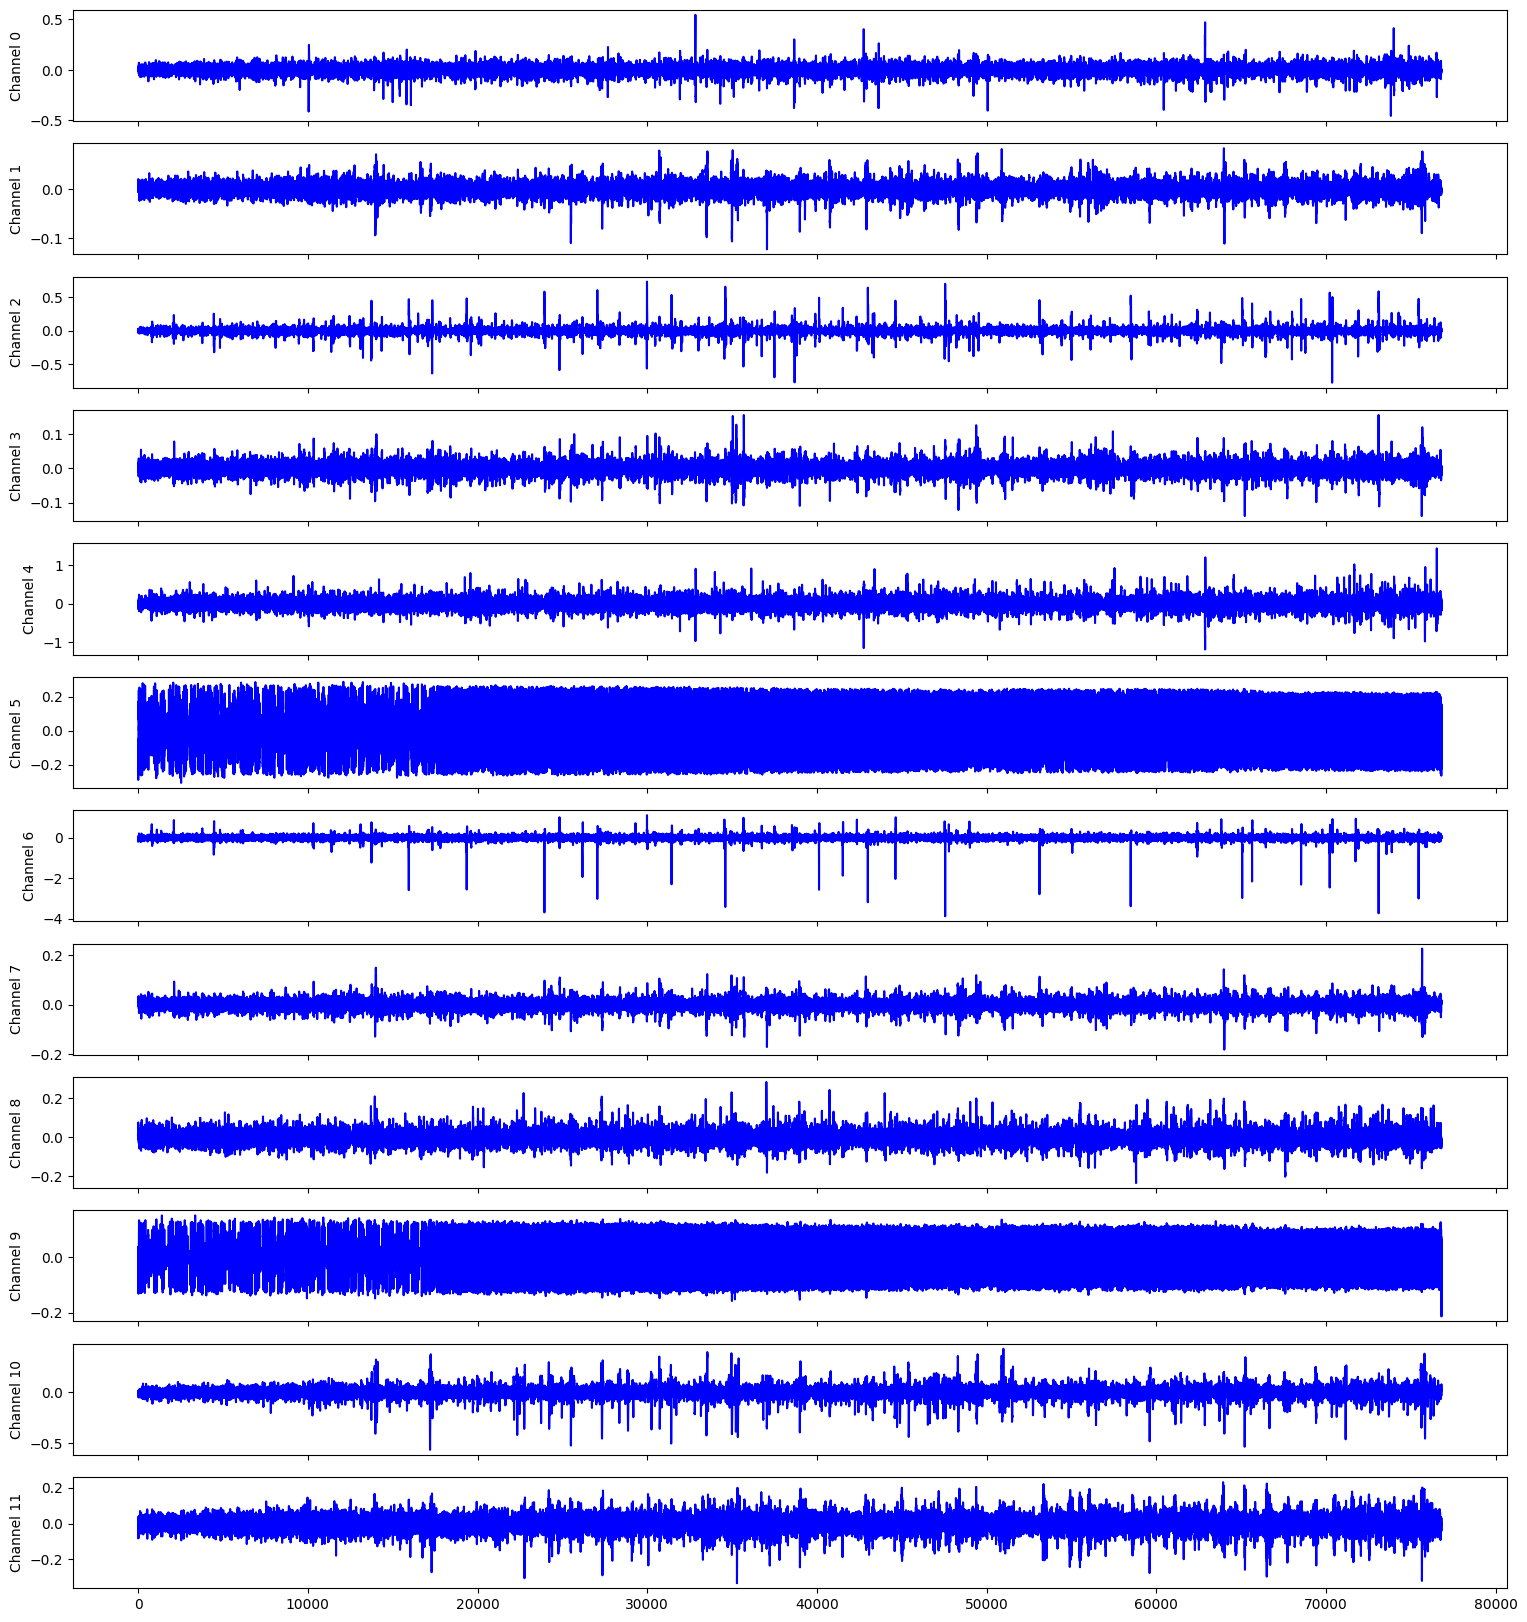

In [15]:
# put arrays in dictionary for labels
pre_seiz = {}
for i in range(len(eeg_data)):
    pre_seiz[f"channel_{i}"] = eeg_data[i][samples:samples+samples]

filtered_pre = []

for ch in pre_seiz:
    filt_data = filtfilt(b, a, pre_seiz[ch])
    filtered_pre.append(filt_data)

# plot to compare
time = [i for i in range(len(filtered_pre[0]))]

fig, axs = plt.subplots(len(filtered_pre), 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(len(filtered_pre)):
    axs[c].plot(time, filtered_pre[c], 'b')
    axs[c].set_ylabel(f"Channel {c}")

# with high passed filtering

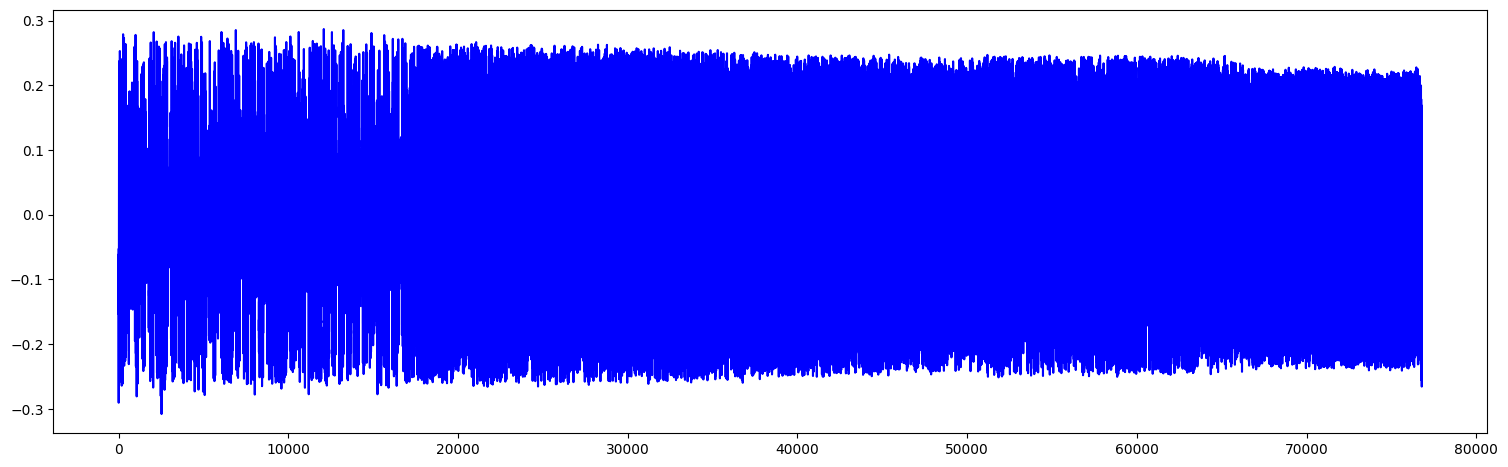

In [16]:
# initial channel data

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(time, filtered_pre[5], 'b')

In [17]:
# compute FFT 

magnitudes = np.fft.rfft(filtered_pre[3])

# estimating sample rate as "256"
sample_freq = np.fft.rfftfreq(filtered_pre[3].shape[0], 1 / 128)

print(sample_freq.shape)
print(magnitudes.shape)

(38401,)
(38401,)


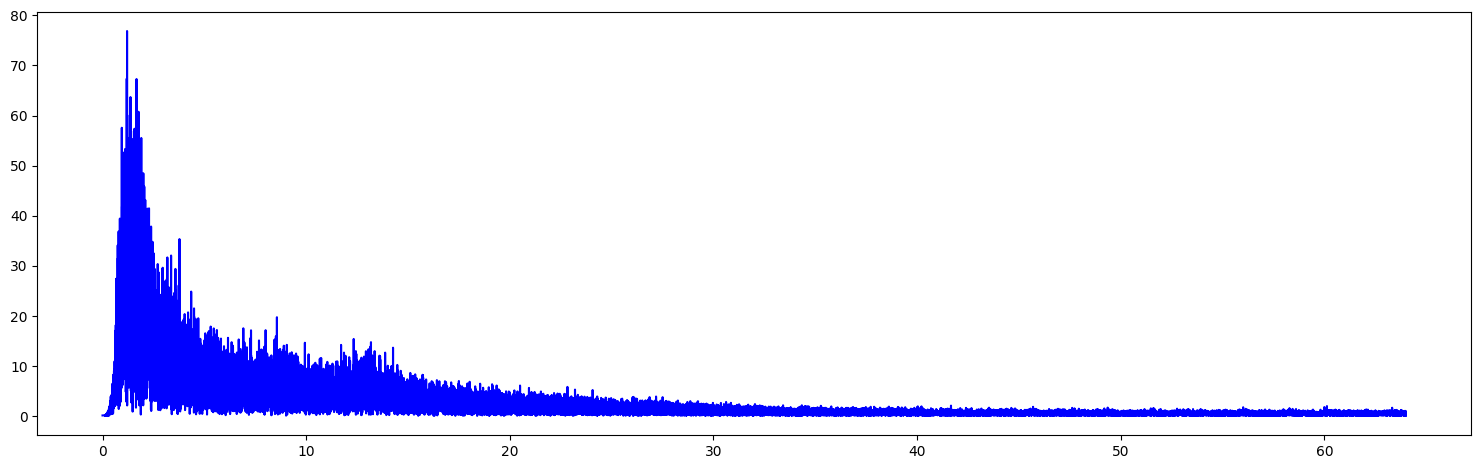

In [18]:
fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(sample_freq, abs(magnitudes), 'b')

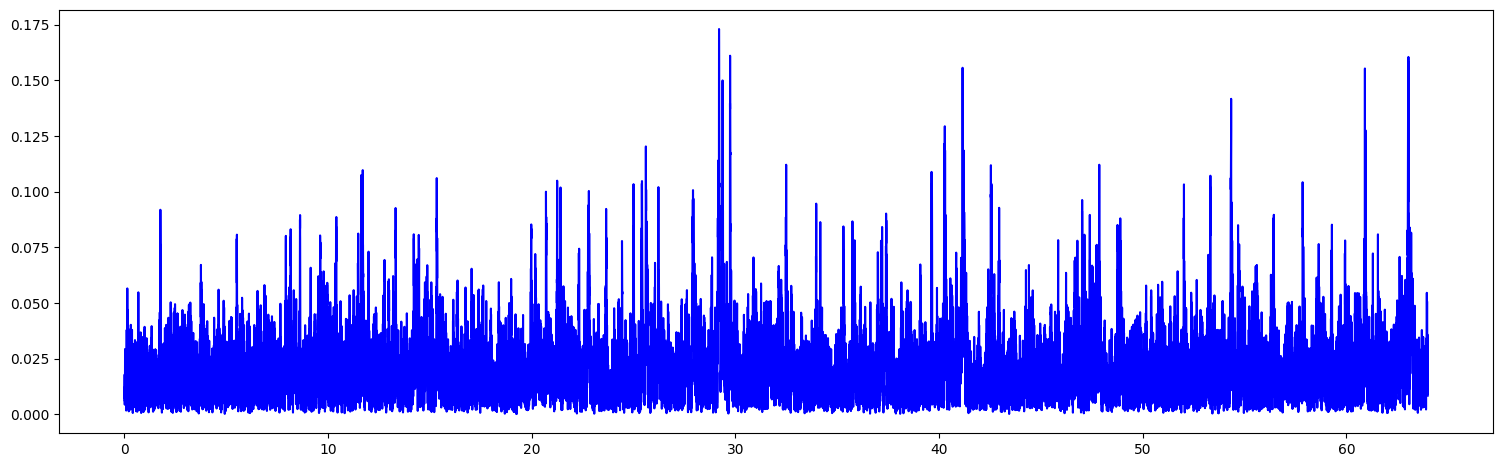

In [19]:
# amplitude of fourier
amplitudes = abs(magnitudes)
phase = np.angle(magnitudes)

lf = np.log(amplitudes) 

length = len(lf)
val = (1 / length ** 2)
q_matrix = np.full((length, length), val)
alf = np.dot(q_matrix, lf.T) 

rf = lf - alf
salient_pre = abs(np.fft.ifft(np.exp(rf + phase * 1j)))

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(sample_freq, salient_pre, 'b')

In [20]:
diffs = salient_pre - salient_non

print(np.mean(diffs), np.std(diffs, ddof=1))

-0.021086566139329896 0.03600382589550024


In [21]:
diffs

array([ 0.00379604, -0.02872562, -0.03425401, ..., -0.00316384,
       -0.02188176, -0.0003467 ])

In [25]:
# change point experiment
from sdt.changepoint import BayesOnline

tot = np.concatenate((salient_non, salient_pre))

len(tot)

76802

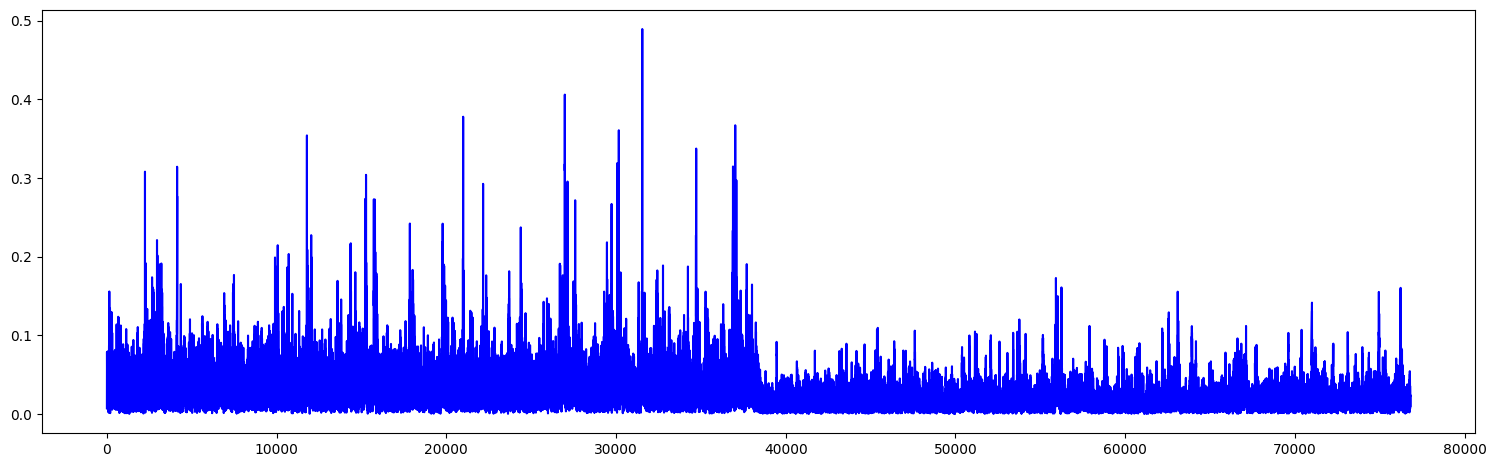

In [26]:
fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

times = [i for i in range(len(tot))]

ax.plot(times, tot, 'b')

In [44]:
# aim for
len(salient_non)

38401

In [68]:
cpd = BayesOnline()

for i in range(0, len(tot), 16):
    print(f"STEP {i}")
    cpd.update(tot[i])

    prob = cpd.get_probabilities(3)
    if len(prob) >= 1 and np.any(prob[1:] > 0.80):
        print("BREAK!")
        break

STEP 0
STEP 16
STEP 32
STEP 48
STEP 64
STEP 80
STEP 96
STEP 112
STEP 128
STEP 144
STEP 160
STEP 176
STEP 192
STEP 208
STEP 224
STEP 240
STEP 256
STEP 272
STEP 288
STEP 304
STEP 320
STEP 336
STEP 352
STEP 368
STEP 384
STEP 400
STEP 416
STEP 432
STEP 448
STEP 464
STEP 480
STEP 496
STEP 512
STEP 528
STEP 544
STEP 560
STEP 576
STEP 592
STEP 608
STEP 624
STEP 640
STEP 656
STEP 672
STEP 688
STEP 704
STEP 720
STEP 736
STEP 752
STEP 768
STEP 784
STEP 800
STEP 816
STEP 832
STEP 848
STEP 864
STEP 880
STEP 896
STEP 912
STEP 928
STEP 944
STEP 960
STEP 976
STEP 992
STEP 1008
STEP 1024
STEP 1040
STEP 1056
STEP 1072
STEP 1088
STEP 1104
STEP 1120
STEP 1136
STEP 1152
STEP 1168
STEP 1184
STEP 1200
STEP 1216
STEP 1232
STEP 1248
STEP 1264
STEP 1280
STEP 1296
STEP 1312
STEP 1328
STEP 1344
STEP 1360
STEP 1376
STEP 1392
STEP 1408
STEP 1424
STEP 1440
STEP 1456
STEP 1472
STEP 1488
STEP 1504
STEP 1520
STEP 1536
STEP 1552
STEP 1568
STEP 1584
STEP 1600
STEP 1616
STEP 1632
STEP 1648
STEP 1664
STEP 1680
STEP 1696
S

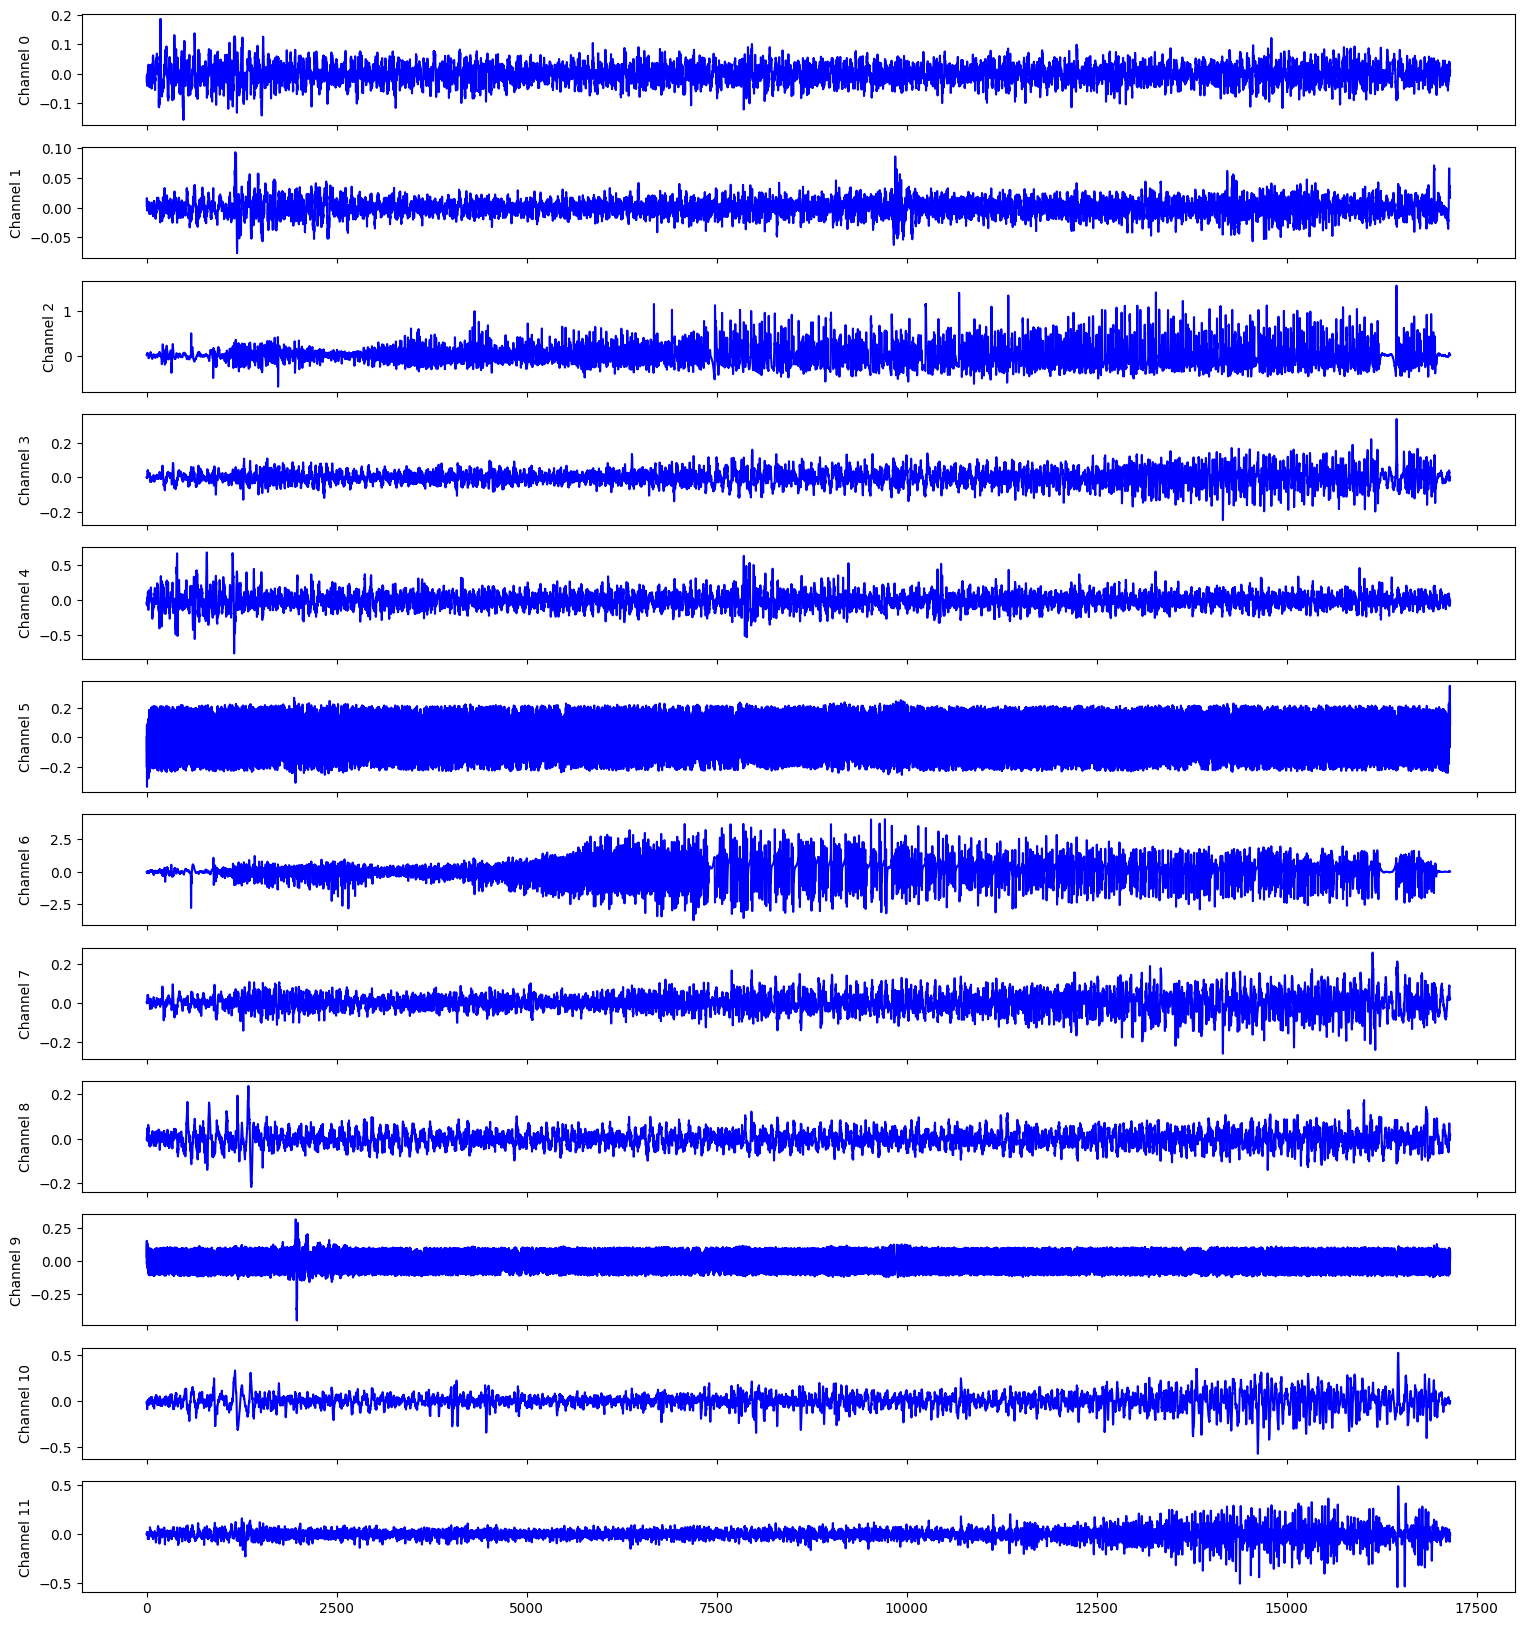

In [ ]:
# try same with seizure data

# put arrays in dictionary for labels
seiz = {}
for i in range(len(eeg_data)):
    seiz[f"channel_{i}"] = eeg_data[i][samples+samples:]

filtered_seiz = []

for ch in seiz:
    filt_data = filtfilt(b, a, seiz[ch])
    filtered_seiz.append(filt_data)

# plot to compare
time = [i for i in range(len(filtered_seiz[0]))]

fig, axs = plt.subplots(len(filtered_seiz), 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(len(filtered_seiz)):
    axs[c].plot(time, filtered_seiz[c], 'b')
    axs[c].set_ylabel(f"Channel {c}")

# with high passed filtering

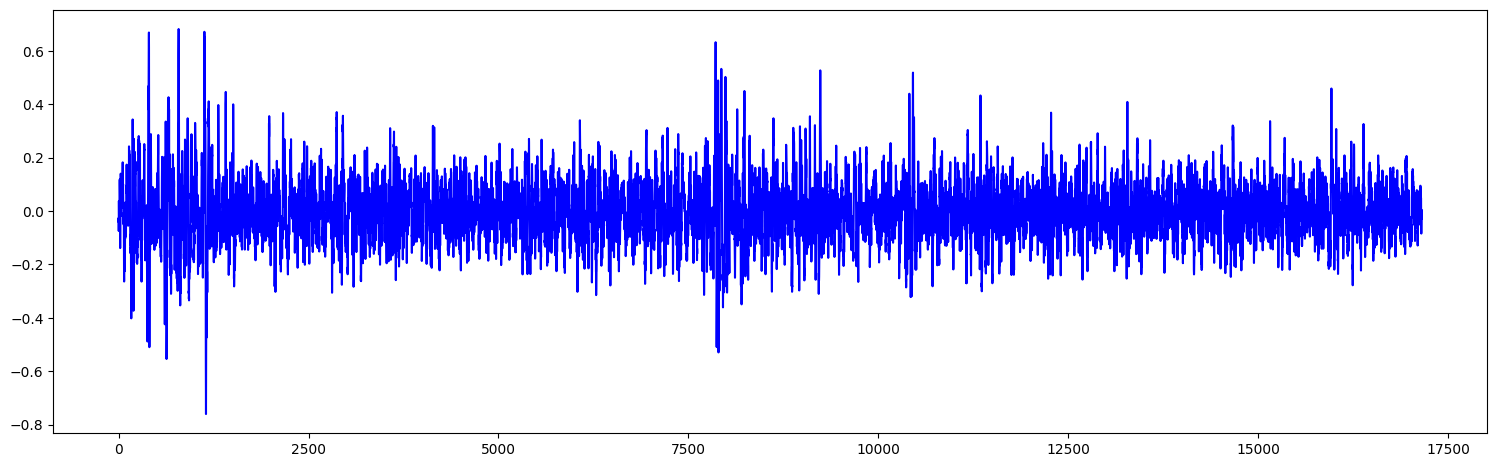

In [ ]:
# initial channel data

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(time, filtered_seiz[5], 'b')

In [ ]:
# compute FFT 

magnitudes = np.fft.rfft(filtered_pre[5])

# estimating sample rate as "256"
sample_freq = np.fft.rfftfreq(filtered_pre[5].shape[0], 1 / 128)

print(sample_freq.shape)
print(magnitudes.shape)

(38401,)
(38401,)


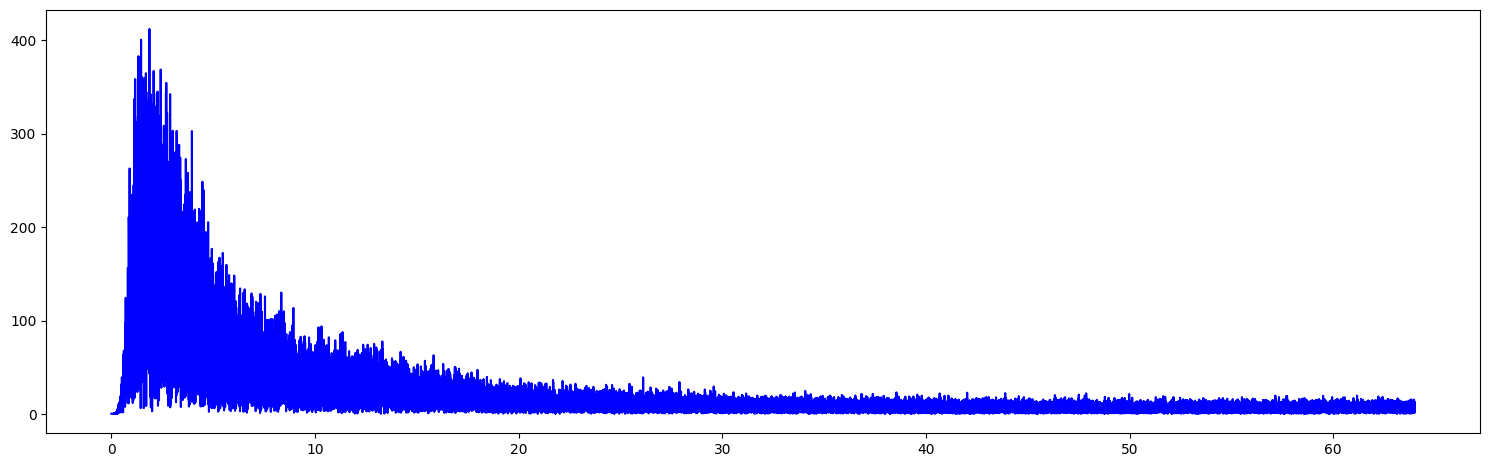

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(sample_freq, abs(magnitudes), 'b')

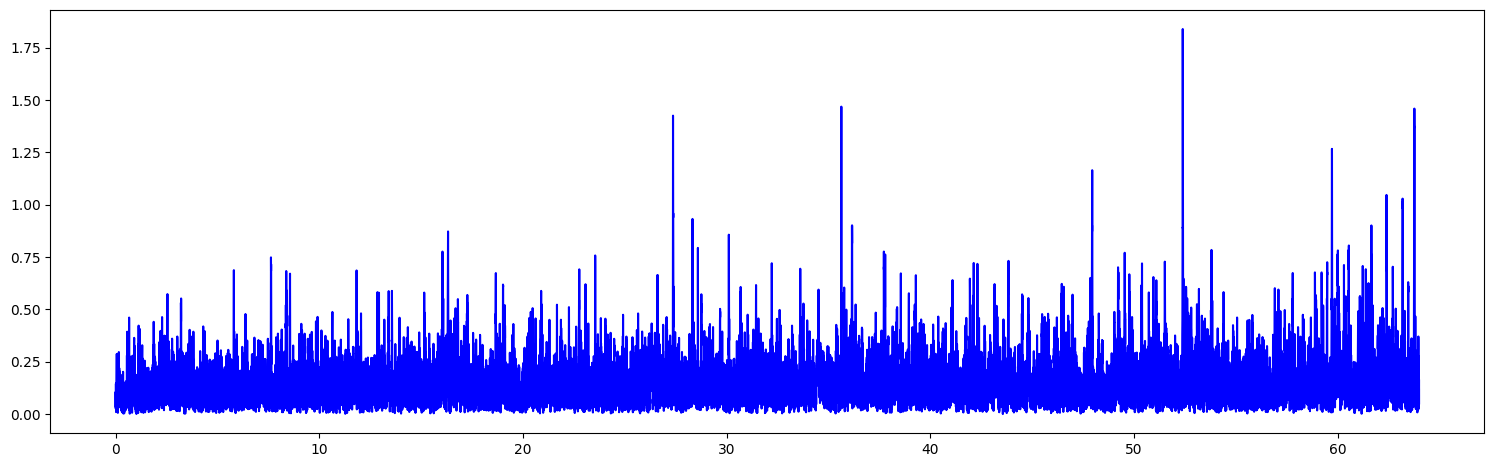

In [ ]:
# amplitude of fourier
amplitudes = abs(magnitudes)
phase = np.angle(magnitudes)

lf = np.log(amplitudes) 

length = len(lf)
val = (1 / length ** 2)
q_matrix = np.full((length, length), val)
alf = np.dot(q_matrix, lf.T) 

rf = lf - alf
salient_seiz = abs(np.fft.ifft(np.exp(rf + phase * 1j)))

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(18.5, 5.5)

ax.plot(sample_freq, salient_seiz, 'b')

In [ ]:
diffs = salient_seiz - salient_pre

print(np.mean(diffs), np.std(diffs, ddof=1))

0.14647623745229812 0.11904295839177141
